In [30]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

# Load your dataset into a Pandas DataFrame
data = pd.read_excel('../data/爬取的数据_cleaned_Price缺失较多-无地区信息.xlsx')
# print(data.dtypes)
data = data.loc[0:, ['Basics.Length (ft)',
 'Propulsion.TotalPower (hp)',
 'Specifications.Accommodations.DoubleBerths',
 'Specifications.Accommodations.Cabins',
 'Specifications.Accommodations.Heads',
 'Propulsion.EngineYear',
 'Specifications.Speed&Distance.CruisingSpeed (kn)',
 'Specifications.Speed&Distance.MaxSpeed (kn)',
 'Specifications.Dimensions.LengthOnDeck (ft)',
 'Specifications.Dimensions.LengthAtWaterline (ft)',
 'Specifications.Dimensions.MaxBridgeClearance (ft)', 'Price']]



# One-hot encode categorical features

# 查找所有类型为object的列
object_columns = data.select_dtypes(include=['object']).columns

# 对object类型的列进行独热编码
encoder = OneHotEncoder(sparse=False)
encoded_columns = encoder.fit_transform(data[object_columns])

# 将独热编码后的列合并到原始数据中，删除原始的object类型列
encoded_columns_df = pd.DataFrame(encoded_columns, columns=encoder.get_feature_names_out(object_columns))
data = pd.concat([data.drop(object_columns, axis=1), encoded_columns_df], axis=1)

print(data.dtypes)


Basics.Length (ft)                                   float64
Propulsion.TotalPower (hp)                           float64
Specifications.Accommodations.DoubleBerths           float64
Specifications.Accommodations.Cabins                 float64
Specifications.Accommodations.Heads                  float64
Propulsion.EngineYear                                float64
Specifications.Speed&Distance.CruisingSpeed (kn)     float64
Specifications.Speed&Distance.MaxSpeed (kn)          float64
Specifications.Dimensions.LengthOnDeck (ft)          float64
Specifications.Dimensions.LengthAtWaterline (ft)     float64
Specifications.Dimensions.MaxBridgeClearance (ft)    float64
Price                                                  int64
dtype: object


In [31]:
# Define the features and label
X = data.drop(columns=['Price'])
y = data['Price']

print(X.shape)
print(y.shape)

(1159, 11)
(1159,)


In [32]:
# split the train set and the test set
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [33]:
print(X.dtypes)

print(y.dtypes)

Basics.Length (ft)                                   float64
Propulsion.TotalPower (hp)                           float64
Specifications.Accommodations.DoubleBerths           float64
Specifications.Accommodations.Cabins                 float64
Specifications.Accommodations.Heads                  float64
Propulsion.EngineYear                                float64
Specifications.Speed&Distance.CruisingSpeed (kn)     float64
Specifications.Speed&Distance.MaxSpeed (kn)          float64
Specifications.Dimensions.LengthOnDeck (ft)          float64
Specifications.Dimensions.LengthAtWaterline (ft)     float64
Specifications.Dimensions.MaxBridgeClearance (ft)    float64
dtype: object
int64


In [37]:
import xgboost as xgb
import numpy as np
model = xgb.XGBRegressor(objective='reg:squarederror', n_estimators=100, max_depth=3)
model.fit(X_train, np.log(y_train))


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=3, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [38]:
from sklearn.metrics import mean_squared_error

y_pred = model.predict(X_test)
y_pred = np.exp(y_pred)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 2646021216126.6426


In [36]:
import shap

# Initialize the explainer
explainer = shap.Explainer(model)

# Calculate SHAP values for the test set
shap_values = explainer(X_test)


ntree_limit is deprecated, use `iteration_range` or model slicing instead.


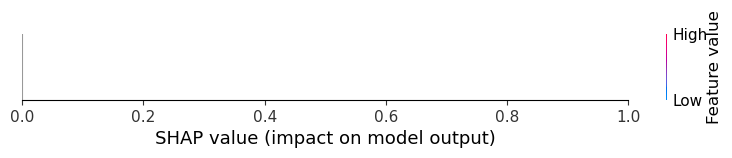

In [24]:
# Filter the SHAP values for the 'Geographic Region' features
geographic_region_shap_values = shap_values[:, X_test.columns.str.startswith('Geographic Region')]

# Plot the summary plot for the 'Geographic Region' features
shap.summary_plot(geographic_region_shap_values.values, X_test.loc[:, X_test.columns.str.startswith('Geographic Region')])
